In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('./../figures/plotting.mplstyle')
np.random.seed(333)
from scipy.special import erf

# Population 1: Gaussian

Assume an astrophysical population distributed as $N(0.05,0.1)$:

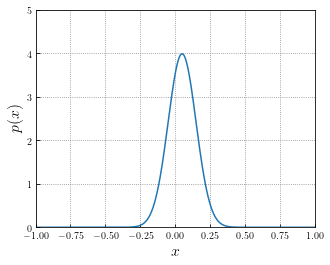

In [2]:
# Parameters describing population
mu_pop = 0.05
sig_pop = 0.1

# Compute and plot probability density
# Note that we are not worrying too much about normalization over the (-1,+1) range,
# since distribution width is much less than this range
xs = np.linspace(-1,1,1000)
ys = np.exp(-(xs-mu_pop)**2/(2.*sig_pop**2))/np.sqrt(2.*np.pi*sig_pop**2)

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(xs,ys)
ax.set_xlim(-1,1)
ax.set_ylim(0,5)
ax.set_xlabel("$x$",fontsize=16)
ax.set_ylabel("$p(x)$",fontsize=16)
plt.show()

Create simulated posterior samples of events randomly selected from this population.

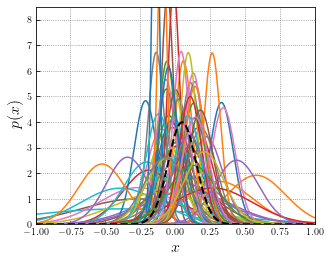

In [3]:
# Number of observations
nObs = 300

# Draw true values
true_chis = np.random.normal(size=nObs,loc=mu_pop,scale=sig_pop)

# Draw log-normally distributed measurement uncertainties
logsig_obs = np.random.normal(loc=-0.9,scale=0.3,size=nObs)
sig_obs = 10.**logsig_obs

# Draw new "observed" max likelihood values
obs_chis = np.random.normal(loc=true_chis,scale=sig_obs)

# Plot individual likelihoods
fig,ax = plt.subplots(figsize=(5,4))
for i in range(69):
    xs = np.linspace(-1,1,300)
    ys = np.exp(-(obs_chis[i]-xs)**2/(2.*sig_obs[i]**2))/np.sqrt(2.*np.pi*sig_obs[i]**2)
    ax.plot(xs,ys)
    
# Plot underyling population
xs = np.linspace(-1,1,1000)
ys = np.exp(-(xs-mu_pop)**2/(2.*sig_pop**2))/np.sqrt(2.*np.pi*sig_pop**2)
ax.plot(xs,ys,color='black',ls='--',lw=2)

# Misc formatting
ax.set_xlim(-1,1)
ax.set_ylim(0,8.5)
ax.set_xlabel("$x$",fontsize=16)
ax.set_ylabel("$p(x)$",fontsize=16)
plt.show()

# For each event, draw a set of posterior samples
sampleDict = {}
for i in range(nObs):
    
    # Draw samples from a Gaussian centered on the max-likelihood value
    samps = np.random.normal(size=1000,loc=obs_chis[i],scale=sig_obs[i])
    
    # If any samples fall outside our physical (-1,+1) interval, redraw
    while np.any(np.abs(samps)>1):
        
        # Find any samples falling outside boundary
        to_replace = (samps<-1) + (samps>1)
        n_to_replace = samps[to_replace].size
        
        # Overwrite
        samps[to_replace] = np.random.normal(size=n_to_replace,loc=obs_chis[i],scale=sig_obs[i])
        
    # Store sample draws
    sampleDict[i] = {'samps':samps}
    
# Save!
np.save('gaussian_samples_varyingUncertainty.npy',sampleDict)

# Population 2: Gaussian + Spike

Assume an astrophysical population distributed as a mixture between $N_{[0,1]}(0.5,0.3)$ and a delta function at zero:

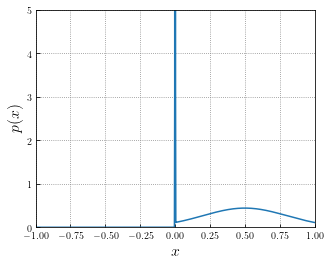

In [4]:
# Parameters describing population
mu_pop = 0.5
sig_pop = 0.3
f_gaussian = 0.3

# Compute and plot probability density
# Note that we are not worrying too much about normalization over the (-1,+1) range,
# since distribution width is much less than this range
xs = np.linspace(-1,1,1000)
ys_gaussian = np.exp(-(xs-mu_pop)**2/(2.*sig_pop**2))*np.sqrt(2./(np.pi*sig_pop**2))/ \
        (erf((1.-mu_pop)/np.sqrt(2.*sig_pop**2)) - erf((0.-mu_pop)/np.sqrt(2.*sig_pop**2)))
ys_gaussian[xs<0] = 0
ys_spike = np.exp(-xs**2/(2.*0.001**2))/np.sqrt(2.*np.pi*0.001**2)
ys = f_gaussian*ys_gaussian + (1.-f_gaussian)*ys_spike

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(xs,ys)
ax.set_xlim(-1,1)
ax.set_ylim(0,5)
ax.set_xlabel("$x$",fontsize=16)
ax.set_ylabel("$p(x)$",fontsize=16)
plt.show()

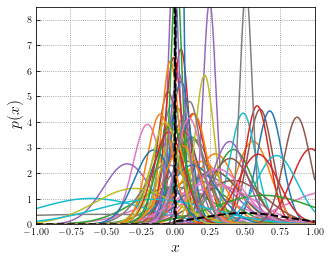

In [5]:
# Number of injections
nObs = 300

# Draw true underlying values
true_chis = np.zeros(nObs)
for i in range(nObs):
    
    # Randomly assign events to gaussian or spike
    if np.random.random()<f_gaussian:
        
        # If assigned to gaussian, repeatedly draw until we get something in the (0,1) interval
        true_chis[i] = 1.5
        while(true_chis[i]>1 or true_chis[i]<0):
            true_chis[i] = np.random.normal(loc=mu_pop,scale=sig_pop)
    
    # Spike events
    else:
        true_chis[i] = 0.

# Draw log-normally distributed measurement uncertainties
logsig_obs = np.random.normal(loc=-0.9,scale=0.3,size=nObs)
sig_obs = 10.**logsig_obs

# Add varying measurement uncertainties to produce new max likelihood value
obs_chis = np.random.normal(loc=true_chis,scale=sig_obs)

# Plot individual likelihoods
fig,ax = plt.subplots(figsize=(5,4))
for i in range(69):
    event_xs = np.linspace(-1,1,300)
    event_ys = np.exp(-(obs_chis[i]-event_xs)**2/(2.*sig_obs[i]**2))/np.sqrt(2.*np.pi*sig_obs[i]**2)
    ax.plot(event_xs,event_ys)
    
# Plot underyling population
ax.plot(xs,ys,color='black',ls='--',lw=2)

# Misc formatting
ax.set_xlim(-1,1)
ax.set_ylim(0,8.5)
ax.set_xlabel("$x$",fontsize=16)
ax.set_ylabel("$p(x)$",fontsize=16)
plt.show()

# For each event, draw a set of posterior samples
sampleDict = {}
for i in range(nObs):
    
    # Draw samples from a Gaussian centered on the max-likelihood value
    samps = np.random.normal(size=1000,loc=obs_chis[i],scale=sig_obs[i])
    
    # If any samples fall outside our physical (-1,+1) interval, redraw
    while np.any(np.abs(samps)>1):
        
        # Find any samples falling outside boundary
        to_replace = (samps<-1) + (samps>1)
        n_to_replace = samps[to_replace].size
        
        # Overwrite
        samps[to_replace] = np.random.normal(size=n_to_replace,loc=obs_chis[i],scale=sig_obs[i])
        
    # Store sample draws
    sampleDict[i] = {'samps':samps}
    
np.save('gaussian_spike_samples_varyingUncertainty.npy',sampleDict)

# Population 3: Spike

Assume an astrophysical population distributed as a delta function at zero:

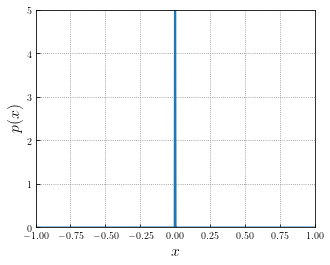

In [6]:
xs = np.linspace(-1,1,1000)
ys = np.exp(-xs**2/(2.*0.001**2))/np.sqrt(2.*np.pi*0.001**2)

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(xs,ys)
ax.set_xlim(-1,1)
ax.set_ylim(0,5)
ax.set_xlabel("$x$",fontsize=16)
ax.set_ylabel("$p(x)$",fontsize=16)
plt.show()

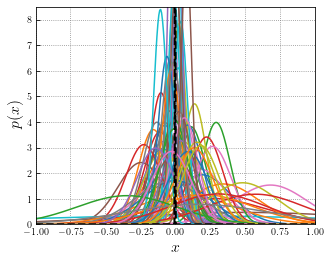

In [7]:
# Number of injections
nObs = 300

# Draw true underlying values
true_chis = np.zeros(nObs)

# Draw log-normally distributed measurement uncertainties
logsig_obs = np.random.normal(loc=-0.9,scale=0.3,size=nObs)
sig_obs = 10.**logsig_obs

# Add varying measurement uncertainties to produce new max likelihood value
obs_chis = np.random.normal(loc=true_chis,scale=sig_obs)

# Plot individual likelihoods
fig,ax = plt.subplots(figsize=(5,4))
for i in range(69):
    event_xs = np.linspace(-1,1,300)
    event_ys = np.exp(-(obs_chis[i]-event_xs)**2/(2.*sig_obs[i]**2))/np.sqrt(2.*np.pi*sig_obs[i]**2)
    ax.plot(event_xs,event_ys)
    
# Plot underyling population
ax.plot(xs,ys,color='black',ls='--',lw=2)

# Misc formatting
ax.set_xlim(-1,1)
ax.set_ylim(0,8.5)
ax.set_xlabel("$x$",fontsize=16)
ax.set_ylabel("$p(x)$",fontsize=16)
plt.show()

# For each event, draw a set of posterior samples
sampleDict = {}
for i in range(nObs):
    
    # Draw samples from a Gaussian centered on the max-likelihood value
    samps = np.random.normal(size=1000,loc=obs_chis[i],scale=sig_obs[i])
    
    # If any samples fall outside our physical (-1,+1) interval, redraw
    while np.any(np.abs(samps)>1):
        
        # Find any samples falling outside boundary
        to_replace = (samps<-1) + (samps>1)
        n_to_replace = samps[to_replace].size
        
        # Overwrite
        samps[to_replace] = np.random.normal(size=n_to_replace,loc=obs_chis[i],scale=sig_obs[i])
        
    # Store sample draws
    sampleDict[i] = {'samps':samps}
    
np.save('spike_samples_varyingUncertainty.npy',sampleDict)

# Population 4: Half Gaussian

Assume an astrophysical population distributed as a half-normal distribution, centered at zero and extending to purely positive values:

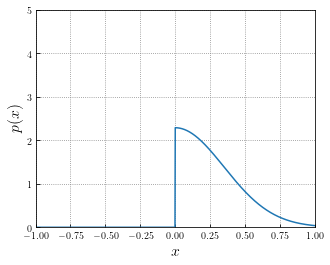

In [8]:
sig_pop = 0.35

xs = np.linspace(-1,1,1000)
ys = np.exp(-xs**2/(2.*sig_pop**2))*np.sqrt(2./(np.pi*sig_pop**2))
ys /= erf(1./np.sqrt(2.*sig_pop**2)) 
ys[xs<0] = 0

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(xs,ys)
ax.set_xlim(-1,1)
ax.set_ylim(0,5)
ax.set_xlabel("$x$",fontsize=16)
ax.set_ylabel("$p(x)$",fontsize=16)
plt.show()

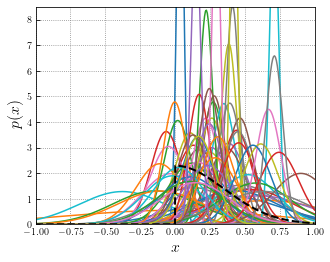

In [9]:
# Number of injections
nObs = 300

# Draw true underlying values
true_chis = np.abs(np.random.normal(loc=0.,scale=sig_pop,size=nObs))
while np.any(true_chis>1):
    to_replace = (true_chis>1)
    n_to_replace = true_chis[to_replace].size
    true_chis[to_replace] = np.abs(np.random.normal(loc=0,scale=sig_pop,size=n_to_replace))

# Draw log-normally distributed measurement uncertainties
logsig_obs = np.random.normal(loc=-0.9,scale=0.3,size=nObs)
sig_obs = 10.**logsig_obs

# Add varying measurement uncertainties to produce new max likelihood value
obs_chis = np.random.normal(loc=true_chis,scale=sig_obs)

# Plot individual likelihoods
fig,ax = plt.subplots(figsize=(5,4))
for i in range(69):
    event_xs = np.linspace(-1,1,300)
    event_ys = np.exp(-(obs_chis[i]-event_xs)**2/(2.*sig_obs[i]**2))/np.sqrt(2.*np.pi*sig_obs[i]**2)
    ax.plot(event_xs,event_ys)
    
# Plot underyling population
ax.plot(xs,ys,color='black',ls='--',lw=2)

# Misc formatting
ax.set_xlim(-1,1)
ax.set_ylim(0,8.5)
ax.set_xlabel("$x$",fontsize=16)
ax.set_ylabel("$p(x)$",fontsize=16)
plt.show()

# For each event, draw a set of posterior samples
sampleDict = {}
for i in range(nObs):
    
    # Draw samples from a Gaussian centered on the max-likelihood value
    samps = np.random.normal(size=1000,loc=obs_chis[i],scale=sig_obs[i])
    
    # If any samples fall outside our physical (-1,+1) interval, redraw
    while np.any(np.abs(samps)>1):
        
        # Find any samples falling outside boundary
        to_replace = (samps<-1) + (samps>1)
        n_to_replace = samps[to_replace].size
        
        # Overwrite
        samps[to_replace] = np.random.normal(size=n_to_replace,loc=obs_chis[i],scale=sig_obs[i])
        
    # Store sample draws
    sampleDict[i] = {'samps':samps}
    
np.save('half_normal_samples_varyingUncertainty.npy',sampleDict)